In [1]:
import gym
from action_interfaces.action import TrialAction 
from action_interfaces.srv import Reward
import rclpy
from rclpy.action import ActionClient
from rclpy.node import Node
import numpy as np
import time
from std_srvs.srv import Empty

In [2]:
import stable_baselines3
from stable_baselines3 import DQN

In [3]:
rclpy.init()

In [4]:
%config Completer.use_jedi = False

In [5]:
class RWEnv(gym.Env, Node):
    def __init__(self):
        super().__init__('gymenv_node2')
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(low=np.array([0,1]),high=np.array([0,1]),shape=(2,))
        self.normalize=True
        self.state = np.array([0.0,0.0])#self.get_state()
#         t = gymI.get_rigid_transform(env,0)
#         self.last_pos = t.p.y
        self.step_count = 0
        self.tmr = time.time()
        self.draw = False
        self.eprew = 0
        self._action_client = ActionClient(self, TrialAction, 'move')
        self._action_client.wait_for_server()
        self.cli = self.create_client(Empty, 'reset_env')
        self.rewresetserv = self.create_client(Empty, 'reset_reward')
        self.progress_serv = self.create_client(Reward, 'get_progress')
        self.rewserv = self.create_client(Reward, 'get_reward')
        while not self.cli.wait_for_service(timeout_sec=1.0):
            self.get_logger().info('service not available, waiting again... EnvReset')
        while not self.rewserv.wait_for_service(timeout_sec=1.0):
            self.get_logger().info('service not available, waiting again... Rew')
        while not self.rewresetserv.wait_for_service(timeout_sec=1.0):
            self.get_logger().info('service not available, waiting again... RewReset')
        self.joint_changed = 0
        self.step_count = 0
        
        
    def step(self, action):
        print(str(action)+".",end="")
        info = {}
        done=False
        self.old_state=self.state
#         print("state",self.state)
        self.f = self.apply_action(action)
#         self.gymI.set_actor_dof_position_targets(self.env, self.actor_handle, [self.bin_to_val(0),self.bin_to_val(1)])
#         print("state:",a, )
        
        news = self.simulate()
#         print(type(news))
        if self.joint_changed==0:
            self.state[self.joint_changed] = np.float32(news)
            self.state = np.array([news, self.state[1]])
#             print("j0",self.joint_changed,self.state)
        else:
#             self.state[self.joint_changed] = 1.0-news
#             print("j1",self.joint_changed,self.state)
            self.state = np.array([self.state[0],1-news])
        s = np.round(self.state,decimals=2)
#         print(s,news)
        reward = 0
        done=False
        self.step_count+=1
        rewFuture = self.rewserv.call_async(Reward.Request())
        while not rewFuture.done():
            rclpy.spin_once(self)
            time.sleep(0.01)
        reward = rewFuture.result().reward
        done = rewFuture.result().done
        if done:
            print("Reached end!")
        if self.step_count > 100:
            done = True
        print(round(reward,2),end="|")
        return s, reward , done , info
    
    def reset(self):
        self.step_count = 0
        self.state=np.array([0,1])
        self.eprew = 0
        self.future = self.cli.call_async(Empty.Request())
#         time.sleep(4)
        while not self.future.done():
            rclpy.spin_once(self)
            time.sleep(0.01)
        print("done",self.future.result())
        time.sleep(0.5)
        self.rewresetserv.call_async(Empty.Request())
        print("resetting env")
        
        return self.state
    
    
    def close (self):
        self.gymI.destroy_viewer(self.viewer)
        self.gymI.destroy_sim(self.sim)
        
#     def get_state(self):
#         return np
    
    def apply_action(self,a):
        joint = 0 if a in [0,2] else 1
        direction= 1 if a in [1,2] else -1
#         if joint==1:
#             direction *=-1
        goal_msg = TrialAction.Goal()
        goal_msg.joint = joint
        goal_msg.direction = direction
        result = self._action_client.send_goal_async(goal_msg)
        self.joint_changed = joint
        return result
        
        
    def render(self):
        self.draw=True
        
    def get_progress(self):
        rewFuture = self.progress_serv.call_async(Reward.Request())
        while not rewFuture.done():
            rclpy.spin_once(self)
            time.sleep(0.01)
        reward = rewFuture.result().reward
        return reward
    def simulate(self):
        time.sleep(0.1)
#         f = rwenv._action_client.send_goal_async(goal_msg)
#         f.add_done_callback(goal_response_callback)
        while not self.f.done():
            rclpy.spin_once(self)
            time.sleep(0.01)
#         print("F done", self.f.done())
        gh = self.f.result()
        r = gh.get_result_async()
        while not r.done():
            rclpy.spin_once(self)
            time.sleep(0.01)
        res = r.result()
        nextS = res.result.final
#         print(nextS)
        return nextS
        

In [6]:
rwenv = RWEnv()

/home/ros/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [55]:
rwenv.reset()

done std_srvs.srv.Empty_Response()
resetting env


array([0, 1])

In [57]:
strat = [1,2,3,0,1,1,1,1]
rwenv.reset()
for a in strat:
    s,r,_,_ = rwenv.step(a)
    print(a,"->",s,r)

done std_srvs.srv.Empty_Response()
resetting env
1.-0.1|1 -> [0.   0.85] -0.10000000149011612
2.1.71|2 -> [0.15 0.85] 1.7088007926940918
3.-0.1|3 -> [0.15 1.  ] -0.10000000149011612
0.-3.22|0 -> [0. 1.] -3.224903106689453
1.-0.1|1 -> [0.   0.85] -0.10000000149011612
1.-0.1|1 -> [0.  0.7] -0.10000000149011612
1.1.41|1 -> [0.   0.55] 1.4142135381698608
1.1.46|1 -> [0.  0.4] 1.456022024154663


In [8]:
goal_msg = TrialAction.Goal()
goal_msg.joint = 1
goal_msg.direction = 1

In [9]:
def goal_response_callback(future):
        goal_handle = future.result()

        if not goal_handle.accepted:
            self.get_logger().info('Goal rejected :(')
            return

        print('Goal accepted :)')
#         self._get_result_future = goal_handle.get_result_async()

#         self._get_result_future.add_done_callback(self.get_result_callback)

In [9]:
# model = DQN.load("./models/retrained_15")

In [7]:
modelRT = DQN.load("./models/dqn_new_2")

/home/ros/.local/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(
/home/ros/.local/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


In [8]:
model = modelRT

In [45]:
model=DQN.load("./models/DQN_LR0.010_H1_64_H2_0_BS_5000_GS_10_1")

/home/ros/.local/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(
/home/ros/.local/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


In [20]:
env = rwenv
obs = env.reset()
for i in range(50):
    env.render
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print("curr:",action,"->",obs,reward)
rwenv.reset()
#     if done:
#         print("Done")
#         break

done std_srvs.srv.Empty_Response()
resetting env
1.-0.1|curr: 1 -> [0.   0.85] -0.10000000149011612
1.1.2|curr: 1 -> [0.  0.7] 1.2000000476837158
1.1.34|curr: 1 -> [0.   0.55] 1.341640830039978
1.2.04|curr: 1 -> [0.  0.4] 2.0396077632904053
1.2.09|curr: 1 -> [0.   0.25] 2.0880613327026367
1.2.8|curr: 1 -> [0.  0.1] 2.799999952316284
1.2.41|curr: 1 -> [0. 0.] 2.4083189964294434
2.-0.1|curr: 2 -> [0.15 0.  ] -0.10000000149011612
2.-0.1|curr: 2 -> [0.3 0. ] -0.10000000149011612
2.-0.1|curr: 2 -> [0.45 0.  ] -0.10000000149011612
2.-0.1|curr: 2 -> [0.6 0. ] -0.10000000149011612
3.-0.1|curr: 3 -> [0.6  0.15] -0.10000000149011612
0.-0.1|curr: 0 -> [0.45 0.15] -0.10000000149011612
1.1.81|curr: 1 -> [0.45 0.  ] 1.8110769987106323
2.-0.1|curr: 2 -> [0.6 0. ] -0.10000000149011612
3.-0.1|curr: 3 -> [0.6  0.15] -0.10000000149011612
0.-0.1|curr: 0 -> [0.45 0.15] -0.10000000149011612
1.2.09|curr: 1 -> [0.45 0.  ] 2.0880613327026367
2.-0.1|curr: 2 -> [0.6 0. ] -0.10000000149011612
3.-0.1|curr: 3 -> [0

array([0, 1])

In [31]:
env.get_progress()

233.07723999023438

# Rewards
rt: 152, 245,237, 232,233
og: 175, 228

In [ ]:
#retrained: 125
#untrained: 110

In [14]:
rwenv.reset()

done std_srvs.srv.Empty_Response()
resetting env


array([0, 1])

In [20]:
rwenv.get_progress()

0.0

In [ ]:
model.collect_rollouts(rwenva,lambda _ : print("R"),)

In [12]:
env = rwenv
obs = env.reset()
done = False
accRew = 0
while not done:
    env.render
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    accRew += reward
    print("curr:",action,"->",obs,reward)
    if done:
        obs = env.reset()


done std_srvs.srv.Empty_Response()
resetting env
1.-0.1|curr: 1 -> [0.  0.8] -0.10000000149011612
1.-0.1|curr: 1 -> [0.  0.6] -0.10000000149011612
2.1.34|curr: 2 -> [0.2 0.6] 1.341640830039978
1.1.65|curr: 1 -> [0.2 0.4] 1.6492422819137573
1.2.81|curr: 1 -> [0.2 0.2] 2.807133674621582
1.4.22|curr: 1 -> [0.2 0. ] 4.2190046310424805
2.-0.1|curr: 2 -> [0.4 0. ] -0.10000000149011612
2.-0.1|curr: 2 -> [0.6 0. ] -0.10000000149011612
3.-0.1|curr: 3 -> [0.6 0.2] -0.10000000149011612
0.-0.1|curr: 0 -> [0.4 0.2] -0.10000000149011612
1.1.46|curr: 1 -> [0.4 0. ] 1.456022024154663
2.-0.1|curr: 2 -> [0.6 0. ] -0.10000000149011612
3.-0.1|curr: 3 -> [0.6 0.2] -0.10000000149011612
0.-0.1|curr: 0 -> [0.4 0.2] -0.10000000149011612
1.3.0|curr: 1 -> [0.4 0. ] 3.0
2.-0.1|curr: 2 -> [0.6 0. ] -0.10000000149011612
3.-0.1|curr: 3 -> [0.6 0.2] -0.10000000149011612
0.-0.1|curr: 0 -> [0.4 0.2] -0.10000000149011612
1.2.61|curr: 1 -> [0.4 0. ] 2.6076810359954834
done std_srvs.srv.Empty_Response()
resetting env


Retrained: 8.505226485431194 \
OG: 5.302387870848179

In [29]:
accRew

5.302387870848179

In [16]:
for i in range(10):
    env.render
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print("curr:",action,"->",obs,reward)
    if done:
        obs = env.reset()

NameError: name 'obs' is not defined

In [13]:
rwenv.reset()

done std_srvs.srv.Empty_Response()


array([0, 1])

In [13]:
model=DQN("MlpPolicy", rwenv, verbose=2,batch_size=2000,\
          learning_starts=300,learning_rate=0.01,\
          gradient_steps=10,train_freq=(2,"episode"),\
          target_update_interval=500,\
          exploration_fraction=0.5, tensorboard_log="tlog/real_run_2")
model.learn(total_timesteps=8000, log_interval=2,eval_env=rwenv, eval_freq=2000,\
            n_eval_episodes=3,eval_log_path="./logs/",tb_log_name="trial_q")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
done std_srvs.srv.Empty_Response()
resetting env
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to tlog/real_run_2/trial_q_1
-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|0.4|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|0.45|0.67|-0.1|0.51|-0.1|0.41|-0.1|-0.1|-0.1|-0.1|-1.02|0.51|-0.1|-0.1|-0.89|-1.22|0.41|-0.1|0.61|-0.82|-0.1|0.41|0.81|0.9|1.1|-0.1|-0.1|-1.61|-0.1|-2.01|-0.1|-1.61|-1.46|-1.0|-0.1|-0.1|-0.1|0.54|-0.1|-0.1|-0.1|-0.1|-1.26|-1.22|-0.1|done std_srvs.srv.Empty_Response()
resetting env
-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0

-0.1|-0.1|-0.1|-0.1|-0.1|0.54|0.63|0.51|-0.1|-0.1|0.51|-0.82|0.41|0.5|-0.1|0.7|-0.1|0.71|0.95|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-1.22|-0.1|0.71|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-1.41|0.71|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-1.61|-2.0|-0.1|0.7|0.91|-0.1|-0.1|-0.1|-0.1|-0.1|-1.6|0.7|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-1.41|-0.1|-0.1|0.71|-0.1|-0.1|-1.61|0.71|-0.1|-0.1|-1.61|-0.1|-0.1|-1.61|0.61|-1.71|0.63|-0.1|0.81|-0.1|0.71|-0.1|done std_srvs.srv.Empty_Response()
resetting env
-0.1|-0.1|-0.1|-0.1|0.41|0.54|0.61|-0.1|0.51|-0.1|0.7|0.92|0.81|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-1.61|0.71|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-1.61|0.81|-0.1|-0.1|-1.61|0.71|-1.22|0.71|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.

-0.1|-0.1|-0.1|0.42|0.51|0.54|-0.1|0.71|2.2|1.0|-2.24|-0.1|1.22|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-2.43|1.22|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-1.41|0.81|-2.43|1.22|-0.1|-0.1|-2.43|-0.1|1.22|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-1.41|-1.02|1.22|-0.1|-0.1|-0.1|-2.43|1.22|-0.1|-1.22|0.61|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-2.15|1.17|-0.1|done std_srvs.srv.Empty_Response()
resetting env
-0.1|-0.1|-0.1|0.45|0.51|0.45|-0.1|0.81|2.1|-1.89|0.9|1.17|-2.43|1.22|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-2.15|1.17|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0

resetting env
Eval num_timesteps=6000, episode_reward=-9.49 +/- 0.02
Episode length: 101.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 101      |
|    mean_reward      | -9.49    |
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    total timesteps  | 6000     |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 0.101    |
|    n_updates        | 270      |
----------------------------------
-0.1|-0.1|-0.1|-0.1|0.45|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|0.45|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|0.51|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1|-0.1

In [9]:
# rwenv._action_client.wait_for_server()

# f.add_done_callback(goal_response_callback)


# Relearn

In [11]:
def explo_sched(x):
#     print("expo", x)
    if x > 0.9:
        return 0.01
    return 0.3 - 0.3*(1-x)

In [16]:
env=rwenv

In [25]:
# model=DQN.load("./models/DQN_LR0.010_H1_64_H2_64_BS_5000_GS_10_1")
modID = "DQN_LR0.010_H1_64_H2_64_BS_1000_GS_10_4"
# modID= "DQN_LR0.010_H1_64_H2_0_BS_5000_GS_10_1"
modelO=DQN.load("./models/"+modID)

In [26]:
import stable_baselines3.common.utils as su
import torch as th

In [27]:
 policy_kwargs = dict(activation_fn=th.nn.ReLU,
                             net_arch=[64,64])

In [28]:
model = DQN("MlpPolicy", env, verbose=2,batch_size=1000,\
              learning_starts=50,learning_rate=0.01,\
              train_freq=(1,"episode"),gradient_steps=10,\
              target_update_interval=1000,exploration_initial_eps=0.3,exploration_final_eps=0.1,\
              exploration_fraction=0.7, tensorboard_log="tlog/dqn_evals_6",policy_kwargs=policy_kwargs)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [29]:
model.set_parameters({"policy":modelO.get_parameters()["policy"]},exact_match=False)

In [31]:
model.learning_rate=0.000
model.learning_starts=10#200
model.target_update_interval=1000
model.exploration_initial_eps=0.5
model.exploration_final_eps=0.01
model.set_env(env)
model.gradient_steps=1
model.batch_size=1000
model.draw=True
# model.train_freq=su.TrainFreq(3,su.TrainFrequencyUnit.EPISODE)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [32]:
model.exploration_schedule = lambda x : (0.2- 0.2*(1-(x-0.05))) if x<0.96 else 0.01

In [33]:
d = model.get_parameters()

In [30]:
model.learn(total_timesteps=5000,log_interval=1)

done std_srvs.srv.Empty_Response()
resetting env
Logging to tlog/dqn_evals_6/DQN_32
0.-0.1|1.-0.1|3.-0.1|1.1.8|0.2.0|1.-0.1|1.2.33|2.1.41|3.-0.1|2.-2.91|1.1.65|0.-0.1|1.1.65|1.2.09|0.-0.1|3.-4.18|3.-0.1|1.1.56|1.2.0|1.4.56|1.2.09|3.-4.95|2.-0.1|0.-0.1|2.-0.1|3.-2.53|1.2.04|3.-3.42|3.-4.66|1.1.44|3.-2.53|2.-0.1|3.-0.1|2.-0.1|0.-0.1|2.-0.1|2.-0.1|0.-0.1|0.1.4|1.1.2|0.-0.1|0.-0.1|3.-2.43|3.-0.1|1.-0.1|2.-0.1|1.1.22|3.-0.1|0.-0.1|2.-0.1|1.-0.1|1.2.68|2.1.44|1.2.44|1.1.65|2.-0.1|2.-0.1|1.-0.1|3.-0.1|3.-0.1|0.-0.1|1.-0.1|1.-0.1|2.-0.1|3.-0.1|1.1.8|3.2.0|3.-0.1|0.-0.1|1.-0.1|1.1.2|2.-0.1|3.-0.1|3.-0.1|0.-0.1|0.-0.1|1.1.2|3.-4.8|3.-0.1|1.1.22|1.1.22|1.1.6|2.-0.1|3.-2.53|3.-0.1|1.-0.1|1.2.15|2.-0.1|3.-0.1|3.-0.1|0.-0.1|1.-0.1|1.1.26|3.-3.2|1.-0.1|1.-0.1|2.-0.1|3.-0.1|3.-0.1|0.-0.1|3.-0.1|done std_srvs.srv.Empty_Response()
resetting env
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | 8.07     |
|    exploration rate

0.-0.1|0.-0.1|0.1.4|0.-0.1|0.-0.1|0.-0.1|0.1.4|2.-0.1|1.-0.1|2.-0.1|3.-0.1|2.-0.1|1.-0.1|1.-0.1|0.-0.1|0.-0.1|1.1.61|1.1.61|1.2.0|2.-0.1|2.-0.1|3.1.2|0.-0.1|1.-0.1|1.2.91|1.1.61|2.1.28|2.-0.1|3.-0.1|3.-0.1|0.1.6|3.-0.1|0.-0.1|2.-0.1|0.-0.1|1.1.26|2.1.46|3.1.6|0.-0.1|1.-0.1|2.-0.1|3.-0.1|0.-0.1|2.-0.1|0.-0.1|1.-0.1|2.-0.1|1.-0.1|2.-0.1|3.-0.1|0.-0.1|2.-0.1|0.-0.1|3.-0.1|0.-0.1|1.1.44|2.-0.1|3.-0.1|3.-0.1|0.1.4|1.-0.1|1.1.65|2.-0.1|1.1.46|3.-2.53|3.1.6|0.-0.1|1.1.7|2.-0.1|3.-0.1|3.-0.1|0.1.2|1.1.2|1.-0.1|2.-0.1|3.-0.1|0.1.4|1.1.44|2.-0.1|3.-0.1|3.-0.1|0.-2.91|1.1.46|1.-0.1|0.-2.91|2.-0.1|2.-0.1|3.-0.1|0.-0.1|1.2.0|2.-0.1|3.-0.1|3.-0.1|0.-0.1|1.-0.1|1.1.65|2.-0.1|0.-0.1|2.-0.1|3.-0.1|3.-0.1|done std_srvs.srv.Empty_Response()
resetting env
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.2     |
|    ep_rew_mean      | 3.24     |
|    exploration rate | 0.258    |
| time/               |          |
|    episodes         | 8        |
|    fps 

2.-0.1|1.-0.1|1.-0.1|0.-3.22|1.2.0|1.2.0|1.2.88|1.3.49|2.-0.1|2.1.22|2.-0.1|0.-4.31|2.2.16|0.-2.88|2.1.97|3.-0.1|3.-0.1|2.-0.1|3.-0.1|0.-2.53|0.1.26|0.-0.1|1.1.71|1.2.56|1.3.42|2.-0.1|2.-0.1|3.-0.1|3.-0.1|3.-0.1|0.-0.1|0.-0.1|1.2.16|1.2.88|1.2.8|2.1.26|1.2.0|2.-0.1|2.-0.1|0.-0.1|2.-0.1|3.-0.1|1.-0.1|3.-0.1|3.-0.1|3.1.8|3.-0.1|0.-0.1|0.-0.1|0.-0.1|1.Reached end!
1.65|done std_srvs.srv.Empty_Response()
resetting env
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.2     |
|    ep_rew_mean      | 13.7     |
|    exploration rate | 0.225    |
| time/               |          |
|    episodes         | 15       |
|    fps              | 2        |
|    time_elapsed     | 589      |
|    total timesteps  | 1308     |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 0.466    |
|    n_updates        | 140      |
----------------------------------
2.-0.1|3.-0.1|1.1.41|1.-0.1|3.-0.1|1.-0.1|1.1.61|1.1.61|1

1.-0.1|1.-0.1|1.1.44|1.1.41|1.2.69|2.1.97|1.3.21|2.-0.1|1.1.61|2.-0.1|2.-0.1|3.-0.1|3.-0.1|3.-0.1|3.-0.1|2.-0.1|3.-0.1|3.-0.1|3.-0.1|0.-0.1|1.-0.1|0.-0.1|0.-0.1|1.-0.1|0.1.61|1.1.52|1.1.71|0.-0.1|1.2.04|1.3.26|2.-0.1|2.-0.1|1.1.46|1.-0.1|2.-0.1|2.-0.1|3.1.22|3.-0.1|1.-0.1|3.-0.1|3.-0.1|3.-0.1|0.-2.83|0.1.65|0.-0.1|1.1.41|1.1.71|1.Reached end!
2.8|done std_srvs.srv.Empty_Response()
resetting env
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 78.7     |
|    ep_rew_mean      | 19.6     |
|    exploration rate | 0.165    |
| time/               |          |
|    episodes         | 30       |
|    fps              | 2        |
|    time_elapsed     | 1072     |
|    total timesteps  | 2362     |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 0.452    |
|    n_updates        | 290      |
----------------------------------
2.-0.1|1.-0.1|1.-0.1|1.1.61|1.1.9|1.2.09|1.3.22|2.-0.1|1.1.61|2.-0.1|2.-0.1|3

1.-0.1|1.-0.1|1.1.65|2.-0.1|1.1.34|1.2.0|1.3.21|2.-0.1|1.2.61|2.-0.1|2.-0.1|2.-0.1|0.-0.1|3.-0.1|3.1.2|3.1.2|3.1.4|0.1.4|0.-0.1|0.-0.1|1.1.44|1.2.0|0.-0.1|1.2.8|0.-0.1|2.-0.1|1.3.03|2.-0.1|2.-0.1|2.-0.1|1.-0.1|3.-0.1|3.-0.1|3.1.61|3.-0.1|0.-0.1|0.-0.1|0.-0.1|1.2.72|1.2.04|1.Reached end!
2.91|done std_srvs.srv.Empty_Response()
resetting env
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 72.6     |
|    ep_rew_mean      | 20.6     |
|    exploration rate | 0.138    |
| time/               |          |
|    episodes         | 39       |
|    fps              | 2        |
|    time_elapsed     | 1295     |
|    total timesteps  | 2830     |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 0.398    |
|    n_updates        | 380      |
----------------------------------
1.1.46|1.1.2|1.1.6|2.1.61|1.1.44|1.2.04|1.3.67|2.-0.1|1.2.04|2.1.52|2.-0.1|1.-0.1|3.-0.1|3.-0.1|3.1.22|3.-2.43|3.-0.1|3.1.61|3.-2.83|

1.-0.1|1.-0.1|1.1.26|1.1.22|1.1.81|1.3.45|2.-0.1|0.-0.1|2.-0.1|2.-0.1|1.1.61|2.-0.1|2.1.26|3.-0.1|3.-0.1|0.-0.1|0.-0.1|1.2.68|2.-0.1|0.-0.1|1.2.4|2.-0.1|2.-0.1|3.-0.1|3.-0.1|0.-0.1|0.-0.1|1.1.89|1.2.91|2.-0.1|2.-0.1|3.-0.1|3.-0.1|0.-0.1|0.1.2|1.1.44|1.2.4|2.-0.1|2.-0.1|3.-0.1|3.-0.1|0.-0.1|0.-2.68|1.2.53|1.Reached end!
3.22|done std_srvs.srv.Empty_Response()
resetting env
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 70.2     |
|    ep_rew_mean      | 20.6     |
|    exploration rate | 0.1      |
| time/               |          |
|    episodes         | 55       |
|    fps              | 2        |
|    time_elapsed     | 1776     |
|    total timesteps  | 3859     |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 0.406    |
|    n_updates        | 540      |
----------------------------------
1.1.2|1.1.71|1.-0.1|1.1.79|1.2.26|3.-5.01|1.2.72|1.4.66|2.-0.1|1.1.79|2.-0.1|2.1.61|3.-0.1|0.-3.69|0

1.-0.1|1.-0.1|1.-0.1|1.2.69|1.2.26|1.3.61|3.-4.47|1.2.6|2.-0.1|2.-0.1|2.-0.1|3.1.6|0.-0.1|1.1.56|0.-2.53|2.1.46|2.-0.1|3.1.8|0.-0.1|1.1.22|2.1.65|3.1.26|3.-0.1|0.-0.1|0.-0.1|1.2.01|1.3.2|2.-0.1|2.1.26|3.-0.1|0.-0.1|1.1.61|2.1.8|3.-0.1|0.-3.12|1.2.41|2.1.34|1.-0.1|2.-0.1|3.-0.1|0.-0.1|3.-0.1|0.-0.1|0.-2.91|1.3.42|2.-0.1|1.Reached end!
2.83|done std_srvs.srv.Empty_Response()
resetting env
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 67.9     |
|    ep_rew_mean      | 20.6     |
|    exploration rate | 0.1      |
| time/               |          |
|    episodes         | 64       |
|    fps              | 2        |
|    time_elapsed     | 2009     |
|    total timesteps  | 4347     |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 0.421    |
|    n_updates        | 630      |
----------------------------------
1.2.01|1.1.71|1.1.34|1.1.6|1.1.61|1.4.24|2.-0.1|2.-0.1|3.1.2|1.-0.1|1.1.6|2.1.44|2.-0

1.-0.1|1.-0.1|1.2.09|1.1.26|1.2.04|1.3.6|3.-4.02|1.2.91|1.2.16|2.2.15|2.1.22|2.-0.1|2.-0.1|3.-0.1|0.-0.1|3.-0.1|2.-0.1|0.1.8|2.-0.1|0.1.6|0.-2.53|3.-3.69|0.-4.47|1.1.89|1.2.81|1.2.81|2.-0.1|2.-0.1|1.-0.1|2.-0.1|3.-0.1|0.1.2|3.-0.1|1.-0.1|3.-0.1|0.-0.1|2.-0.1|0.-2.91|0.-3.69|1.2.53|1.3.2|2.-0.1|2.1.2|2.1.46|3.-0.1|0.-0.1|3.-0.1|0.-0.1|1.2.4|1.Reached end!
2.81|done std_srvs.srv.Empty_Response()
resetting env
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 65.9     |
|    ep_rew_mean      | 20.7     |
|    exploration rate | 0.1      |
| time/               |          |
|    episodes         | 73       |
|    fps              | 2        |
|    time_elapsed     | 2230     |
|    total timesteps  | 4808     |
| train/              |          |
|    learning_rate    | 0.01     |
|    loss             | 0.389    |
|    n_updates        | 720      |
----------------------------------
1.-0.1|1.-0.1|1.1.34|1.1.6|1.2.97|1.4.57|2.-0.1|2.-0.1|2.1.22|3.

In [97]:
model.save


0.0

In [31]:
model.save("model/retrained/"+modID+"_retrained_new_64_64_5")

In [40]:
model.gamma

0.99

# Retrained
-> DQN35


In [30]:
model.tensorboard_log

'tlog/dqn_evals_5'

In [8]:
env = rwenv
model.learning_rate=0.001
model.learning_starts=200
model.target_update_interval=300
# model.exploration_initial_eps=0.5
# model.exploration_final_eps=0.03
model.set_env(env)
model.batch_size=500
model.gradient_steps=5
model.draw=True
model.exploration_schedule = explo_sched#lambda x : (0.7 - 0.7*(min(1,1-(x-0.1))))
model.tensorboard_log

NameError: name 'model' is not defined

In [18]:
# model.exploration_schedule =explo_sched

In [19]:
model.batch_size

1000

In [31]:
model.learn(total_timesteps=3000,log_interval=1)

done std_srvs.srv.Empty_Response()
resetting env
Logging to tlog/dqn_evals_5/DQN_24
0.-0.1|0.-0.1|2.-0.1|0.-0.1|0.-0.1|3.-0.1|0.-0.1|2.-0.1|3.-0.1|1.-0.1|0.-4.36|0.-0.1|0.-0.1|0.-0.1|2.-0.1|2.-0.1|3.-0.1|2.-0.1|1.-0.1|3.-0.1|2.-0.1|1.-0.1|1.-0.1|3.-0.1|1.-0.1|2.-0.1|2.-0.1|1.-0.1|2.-0.1|0.-0.1|1.-0.1|0.-0.1|1.-0.1|1.-0.1|3.-0.1|3.-0.1|0.-0.1|2.-0.1|0.-0.1|2.-0.1|0.-0.1|3.-0.1|0.-0.1|2.-0.1|0.-0.1|2.-0.1|1.-0.1|0.-0.1|2.-0.1|1.6.18|0.-4.16|2.-0.1|3.-9.31|1.6.8|3.-8.67|2.-0.1|3.-0.1|2.-0.1|0.-0.1|2.-0.1|2.-0.1|3.-0.1|2.-0.1|3.-0.1|2.-0.1|2.-0.1|1.-0.1|2.-0.1|1.-0.1|2.-0.1|3.-0.1|3.-0.1|0.-0.1|2.-0.1|0.-0.1|0.-0.1|1.-0.1|0.-0.1|3.-0.1|2.-0.1|1.-0.1|2.-0.1|0.-0.1|1.-0.1|3.-0.1|0.-0.1|0.-0.1|3.-0.1|3.-0.1|1.-0.1|3.-0.1|3.-0.1|0.-0.1|3.-0.1|2.-0.1|2.-0.1|0.-0.1|2.-0.1|1.-0.1|1.-0.1|3.-0.1|done std_srvs.srv.Empty_Response()
resetting env
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | -23      |
|    exploration 

KeyboardInterrupt: 

In [23]:
# model.save("models/retrained_15")

In [28]:
print(":ji")

:ji


In [39]:
rb = model.replay_buffer

In [42]:
model.save("model/retrained/"+modID+"_retrained_new_3")

# Evaluate models

In [7]:
vals = [[0.01,32,32,5000,10],[0.01,64,64,1000,10],[0.01,64,64,5000,10],[0.001,64,64,5000,10],[0.01,32,16,5000,10]]

In [32]:
def eval_model(model,env):
    obs = env.reset()
    for i in range(50):
        env.render
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        print("curr:",action,"->",obs,reward)
    return rwenv.get_progress()

# retrained results
retrain_4:139.4883575439453
ratrain_5: 120.22062683105469

retrained_64_64_1: 195.11279296875 \
retrained_64_64_2:166.48123168945312 \
retrained_64_64_3: 198.27505493164062 \
retrained_64_64_4: 178.80995178222656 \
retrained_64_64_5:162.00308227539062





In [33]:
eval_model(model,env)

done std_srvs.srv.Empty_Response()
resetting env
1.-0.1|curr: 1 -> [0.   0.85] -0.10000000149011612
1.-0.1|curr: 1 -> [0.  0.7] -0.10000000149011612
1.1.65|curr: 1 -> [0.   0.55] 1.6492422819137573
1.1.56|curr: 1 -> [0.  0.4] 1.5620499849319458
1.2.53|curr: 1 -> [0.   0.25] 2.5298221111297607
1.3.62|curr: 1 -> [0.  0.1] 3.6221539974212646
2.-0.1|curr: 2 -> [0.15 0.1 ] -0.10000000149011612
2.1.61|curr: 2 -> [0.3 0.1] 1.6124515533447266
2.-0.1|curr: 2 -> [0.45 0.1 ] -0.10000000149011612
3.-0.1|curr: 3 -> [0.45 0.25] -0.10000000149011612
3.-0.1|curr: 3 -> [0.45 0.4 ] -0.10000000149011612
0.1.8|curr: 0 -> [0.3 0.4] 1.7999999523162842
0.-0.1|curr: 0 -> [0.15 0.4 ] -0.10000000149011612
1.2.01|curr: 1 -> [0.15 0.25] 2.0099751949310303
1.2.91|curr: 1 -> [0.15 0.1 ] 2.912044048309326
2.-0.1|curr: 2 -> [0.3 0.1] -0.10000000149011612
2.-0.1|curr: 2 -> [0.45 0.1 ] -0.10000000149011612
3.-0.1|curr: 3 -> [0.45 0.25] -0.10000000149011612
3.-0.1|curr: 3 -> [0.45 0.4 ] -0.10000000149011612
0.-0.1|curr:

162.00308227539062

In [10]:
results={}
for v in vals:
    for i in range(5):
        idstr = "DQN_LR%.3f_H1_%d_H2_%d_BS_%d_GS_%d_%d"%(*v,i)
        model = DQN.load("./eval_models/%s"%idstr)
        data = eval_model(model,rwenv)
        if not str(v) in results:
            results[str(v)]=[]
        results[str(v)].append(data)

/home/ros/.local/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(
/home/ros/.local/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


done std_srvs.srv.Empty_Response()
resetting env
1.-0.1|curr: 1 -> [0.   0.85] -0.10000000149011612
1.-0.1|curr: 1 -> [0.  0.7] -0.10000000149011612
1.1.71|curr: 1 -> [0.   0.55] 1.7088007926940918
2.1.56|curr: 2 -> [0.15 0.55] 1.5620499849319458
1.2.13|curr: 1 -> [0.15 0.4 ] 2.1260292530059814
1.2.69|curr: 1 -> [0.15 0.25] 2.6907248497009277
1.3.49|curr: 1 -> [0.15 0.1 ] 3.492849826812744
2.-0.1|curr: 2 -> [0.3 0.1] -0.10000000149011612
2.1.61|curr: 2 -> [0.45 0.1 ] 1.6124515533447266
1.1.61|curr: 1 -> [0.45 0.  ] 1.6124515533447266
2.1.4|curr: 2 -> [0.6 0. ] 1.399999976158142
3.-0.1|curr: 3 -> [0.6  0.15] -0.10000000149011612
3.-0.1|curr: 3 -> [0.6 0.3] -0.10000000149011612
0.-0.1|curr: 0 -> [0.45 0.3 ] -0.10000000149011612
1.-0.1|curr: 1 -> [0.45 0.15] -0.10000000149011612
1.2.04|curr: 1 -> [0.45 0.  ] 2.0396077632904053
2.-0.1|curr: 2 -> [0.6 0. ] -0.10000000149011612
3.-0.1|curr: 3 -> [0.6  0.15] -0.10000000149011612
3.-2.91|curr: 3 -> [0.6 0.3] -2.912044048309326
0.-0.1|curr: 0 -

KeyboardInterrupt: 

In [1]:
import pickle

In [82]:
# pickle.dump(results,open("results_robot.pk","wb"))

In [11]:
results

{'[0.01, 32, 32, 5000, 10]': [116.8417739868164,
  56.14267349243164,
  152.73834228515625]}

In [22]:
results

{'[0.01, 32, 32, 5000, 10]': [166.20770263671875,
  158.11387634277344,
  160.4400177001953,
  165.80108642578125,
  158.861572265625],
 '[0.01, 64, 64, 1000, 10]': [159.10060119628906,
  163.8169708251953,
  161.01242065429688,
  167.86900329589844,
  172.52536010742188],
 '[0.01, 64, 64, 5000, 10]': [172.25563049316406,
  172.52536010742188,
  168.40428161621094,
  172.25563049316406,
  166.33700561523438],
 '[0.001, 64, 64, 5000, 10]': [19.235383987426758,
  32.140316009521484,
  118.25819396972656,
  137.10215759277344,
  98.71676635742188],
 '[0.01, 32, 16, 5000, 10]': [60.13318634033203,
  60.074954986572266,
  60.20797348022461,
  60.13318634033203,
  156.20498657226562]}

In [9]:
import numpy as np

In [8]:
import matplotlib.pyplot as plt

In [4]:
results = pickle.load(open("results_robot.pk","rb"))

In [6]:
retrain_results=  [[195.11279296875 ,166.48123168945312 , 198.27505493164062 , 178.80995178222656 ,162.00308227539062]]

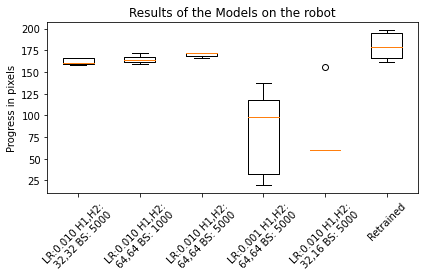

In [15]:
toplot = []
xlabels = []
for k in results.keys():
    vals = results[k]
    toplot.append(vals)
    lablist = eval(k)[:-1]
    labs = "LR:%.3f H1,H2:\n %d,%d BS: %d"%tuple(lablist)
    xlabels.append(labs)
toplot.append(retrain_results)
plt.boxplot(toplot,labels=xlabels+ ["Retrained"])
# plt.boxplot(retrain_results,labels= ["retrained"])
plt.xticks(rotation=45)
plt.ylabel("Progress in pixels")
plt.title("Results of the Models on the robot")
plt.tight_layout()
plt.savefig("boxplot_reward.png")

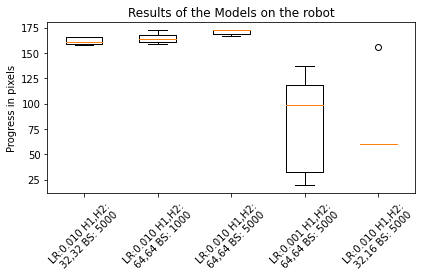

In [26]:
toplot = []
xlabels = []
for k in results.keys():
    vals = results[k]
    toplot.append(vals)
    lablist = eval(k)[:-1]
    labs = "LR:%.3f H1,H2:\n %d,%d BS: %d"%tuple(lablist)
    xlabels.append(labs)
plt.boxplot(toplot,labels=xlabels)
plt.xticks(rotation=45)
plt.ylabel("Progress in pixels")
plt.title("Results of the Models on the robot")
plt.tight_layout()
plt.savefig("boxplot")

In [ ]:
def plotT(k,t):
    ys = []
    xs = []
    for i in range(15):
        cy = []
        for run in range(5):
            cy.append(t[run][i][2])
        ys.append(cy)
    for i in range(15):
        xs.append(t[0][i][1])

    ys = np.array(ys)
    yss=np.std(ys,axis=1)
    ym = np.mean(ys,axis=1)
    lablist = eval(k)[:-1]
    print(lablist)
    labs = "LR:%.3f H1,H2: %d,%d BS: %d"%tuple(lablist)
    
    print(k,'final:%.2f  %.2f'%(ym[-1],yss[-1]))
    print("%.3f & %d & %d & %d  & %.2f & %.2f\\\\"%(*lablist, ym[-1],yss[-1]))
    plt.errorbar(xs,ym,yerr=yss,label=labs)